# Plotting results
This notebook describes how to create plots for the netCDF file(s) obtained after executing `DIVAnd`.     
We will use the [NCDatasets](https://github.com/Alexander-Barth/NCDatasets.jl) module to read the result files and [PyPlot](https://github.com/JuliaPy/PyPlot.jl).

In [1]:
using NCDatasets  
using PyPlot
using DIVAnd
using Statistics
using Missings

Adapt the file directory and name.      
We can use for example the salinity analysis produced by [15-example-analysis](../3-Analysis/15-example-analysis.ipynb).

In [2]:
datadir = "../3-Analysis/"
datafile = joinpath(datadir, "Water_body_Salinity.4Danl.nc")
if isfile(datafile)
    @info("File already exists") 
else
    @error("File does not exist, try to run the notebook 15-example-analysis")
end

┌ Info: File already exists
└ @ Main In[2]:4


Open the dataset from the file for reading

In [3]:
@info("Reading dataset")
ds = Dataset(datafile)

┌ Info: Reading dataset
└ @ Main In[3]:1


Dataset: ../3-Analysis/Water_body_Salinity.4Danl.nc
Group: /

Dimensions
   lon = 76
   lat = 36
   depth = 3
   time = 8
   nv = 2
   observations = 139230
   idlen = 45

Variables
  lon   (76)
    Datatype:    Float64
    Dimensions:  lon
    Attributes:
     units                = degrees_east
     standard_name        = longitude
     long_name            = longitude

  lat   (36)
    Datatype:    Float64
    Dimensions:  lat
    Attributes:
     units                = degrees_north
     standard_name        = latitude
     long_name            = latitude

  depth   (3)
    Datatype:    Float64
    Dimensions:  depth
    Attributes:
     units                = meters
     positive             = down
     standard_name        = depth
     long_name            = depth below sea level

  time   (8)
    Datatype:    Float64
    Dimensions:  time
    Attributes:
     units                = days since 1900-01-01 00:00:00
     standard_name        = time
     long_name            = time
 

From the dataset we can extract the dimensions and variables of interest.     
The `nomissing` function removes the missing values from the variables and dimensions, otherwise the plotting function won't work.

In [4]:
lonr = nomissing(ds["lon"][:]);
latr = nomissing(ds["lat"][:]);
depth = nomissing(ds["depth"][:]);
ttime = nomissing(ds["time"][:]);
salinity = ds["Salinity"][:];

Let's not forget to close the Dataset!

In [5]:
close(ds)

Note that the time variable is an array of dates:

In [6]:
ttime

8-element Array{Dates.DateTime,1}:
 1993-02-16T00:00:00
 1993-05-16T00:00:00
 1993-08-16T00:00:00
 1993-11-16T00:00:00
 1994-02-16T00:00:00
 1994-05-16T00:00:00
 1994-08-16T00:00:00
 1994-11-16T00:00:00

# Create plots
## Simple pseudo color plot
Let's assume we want to plot a given time period at a given depth:

In [7]:
depthplot = 20.;

First we extract the indices of the the time and depth arrays.

In [8]:
timeindex = 4;
depthindex = findall(depth .== depthplot)[1];
@info("Time index: $timeindex")
@info("Depth index: $depthindex")

┌ Info: Time index: 4
└ @ Main In[8]:3
┌ Info: Depth index: 2
└ @ Main In[8]:4


Then we extract the 2-D salinity field. If we are not sure about the dimension order, we can check the matrix size.

In [9]:
@show size(salinity);
salinityplot = salinity[:, :, depthindex, timeindex];
@show size(salinityplot);
@show typeof(salinityplot);

size(salinity) = (76, 36, 3, 8)
size(salinityplot) = (76, 36)
typeof(salinityplot) = Array{Union{Missing, Float32},2}


### First plot
We use the `pcolormesh` (pseudo-color) function, after substituting the `missing`s by `NaN`s so that the land is masked.    

The limits of the color scale are determined from the data.

In [10]:
vmin, vmax = minimum(skipmissing(salinityplot)), maximum(skipmissing(salinityplot))

(15.914517f0, 26.665432f0)

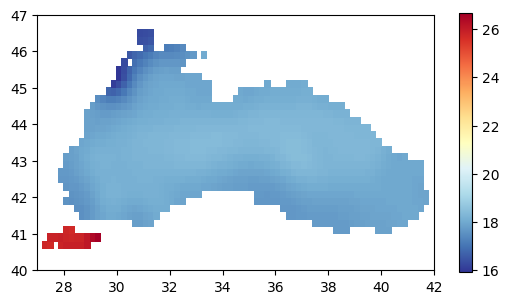

In [11]:
salinityplot = coalesce.(salinityplot, NaN);
pcm = pcolormesh(lonr, latr, permutedims(salinityplot, [2, 1]),vmin=vmin, vmax=vmax)
aspect_ratio = 1/cos(mean(latr) * pi/180)
gca().set_aspect(aspect_ratio)
colorbar(pcm, shrink=0.7)
show()

## Adding a land-sea mask
First you need to read the bathymetry, for consistency it should be the same as the one you used to generate the mask for the analysis.  

In [12]:
bathname = "../data/gebco_30sec_16.nc"
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end
bathisglobal = true
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);

┌ Info: Bathymetry file already downloaded
└ @ Main In[12]:5


Then the mask is added using contourf (filled contour).     
The color can be changed according to your preferences (here: light grey).

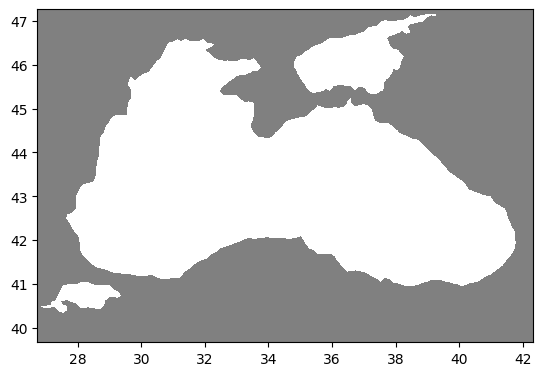

In [13]:
contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
gca().set_aspect(aspect_ratio)

## Contour plots
We explicitely specify the levels to be represented (from 15 to 25).    

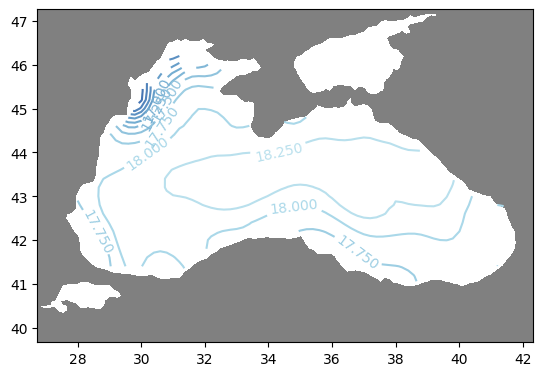

In [14]:
conts = contour(lonr, latr, permutedims(salinityplot,[2,1]), levels=collect(15:.25:25))
clabel(conts, inline=1, fontsize=10);
contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
gca().set_aspect(aspect_ratio)

## Filled contour plots
The aspect is somehow different from the pcolor.

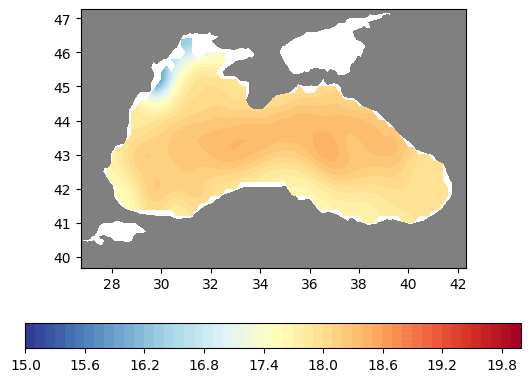

In [15]:
contourf(lonr, latr, permutedims(salinityplot,[2,1]), levels=collect(15:0.1:20))
colorbar(orientation="horizontal")
contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]]);
gca().set_aspect(aspect_ratio)

## Exercise
1. Load the results stored in `Water_body_Salinity.4Danl.nc` (obtained with notebook [15-example-analysis](../3-Analysis/15-example-analysis.ipynb)).
2. Load the observation from `Salinity.bigfile` (also downloaded in notebook [15-example-analysis](../3-Analysis/15-example-analysis.ipynb)).
3. Display the salinity field at 50 meters (for the time period of your choice).
4. Add the observation value at that depth using the `scatter` function.

The solution is available in the notebook [16-plot-results-BlackSea](./solutions/16-plot-results-BlackSea.ipynb) and should look like this:

<img src="./Images/BlackSea_plot.png" width="400px">

## More elaborate plotting
Examples showing how to use `Basemap` or `Cartopy` will be made available in the folder [6-UnderConstruction](../6-UnderConstruction).